# Whatsapp Chat Analysis

In [253]:
import numpy as np
import pandas as pd
import regex
import emoji
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Extraction Functions

In [229]:
def date_time(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result = regex.match(pattern, s)
    if result:
        return True
    return False

def find_author(s):
    s = s.split(":")
    if len(s)==2:
        return True
    else:
        return False

In [230]:
def getDatapoint(line):
    splitline = line.split(' - ')
    dateTime = splitline[0]
    date, time = dateTime.split(", ")
    message = " ".join(splitline[1:])
    if find_author(message):
        splitmessage = message.split(": ")
        author = splitmessage[0]
        message = " ".join(splitmessage[1:])
    else:
        author= None
    return date, time, author, message

## Importing Data

In [231]:
data = []
conversation = 'WhatsApp Chat with Anubharathy.txt'
with open(conversation, encoding="utf-8") as fp:
    fp.readline()
    messageBuffer = []
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if date_time(line):
            if len(messageBuffer) > 0:
                data.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDatapoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

In [232]:
chat_df = pd.DataFrame(data, columns=["Date", 'Time', 'Author', 'Message'])
chat_df['Date'] = pd.to_datetime(chat_df['Date'])

## Exploring Data

In [234]:
chat_df.head()

,Date,Time,Author,Message
0,2021-01-01,10:16 AM,Anubharathy,Tq... Same to u😁
1,2021-01-01,12:15 PM,Veeramanohar,Haa Gm
2,2021-01-01,3:03 PM,Anubharathy,Gm
3,2021-01-01,9:26 PM,Veeramanohar,Oii.. inaiku day epdi pochu ?!
4,2021-01-01,11:05 PM,Anubharathy,Asusual


In [217]:
chat_df.tail()

,Date,Time,Author,Message
11052,2021-10-13,4:07 PM,Veeramanohar,11am ku Gn ah 😂
11053,2021-10-13,4:07 PM,Veeramanohar,Saptiya?
11054,2021-10-13,6:19 PM,Anubharathy,Haa
11055,2021-10-13,6:19 PM,Anubharathy,*gm
11056,2021-10-13,7:40 PM,Veeramanohar,haa


In [186]:
chat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11057 entries, 0 to 11056
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     11057 non-null  datetime64[ns]
 1   Time     11057 non-null  object        
 2   Author   11014 non-null  object        
 3   Message  11057 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 345.7+ KB


In [187]:
authors=chat_df.Author.unique()
authors

array(['Anubharathy', 'Veeramanohar', None], dtype=object)

In [188]:
total_messages=chat_df.shape[0]
total_messages

11057

In [189]:
media_messages = chat_df[chat_df["Message"]=='<Media omitted>'].shape[0]
media_messages

358

### Extracting Emojis

In [190]:
def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X',text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI_ENGLISH for char in word):
            emoji_list.append(word)
    return emoji_list

chat_df['emoji'] = chat_df["Message"].apply(split_count)

emojis = sum(chat_df['emoji'].str.len())
emojis

824

In [191]:
chat_df.head(1)

,Date,Time,Author,Message,emoji
0,2021-01-01,10:16 AM,Anubharathy,Tq... Same to u😁,[😁]


### Extracting URLs

In [192]:
URLPATTERN = r'(https?://\S+)'
chat_df['urlcount'] = chat_df.Message.apply(lambda x: regex.findall(URLPATTERN, x)).str.len()
links = np.sum(chat_df.urlcount)
links

35

### Stats

In [193]:
print(f'Chats between {authors[0]} and {authors[1]}')
print(f'Total Messages: {total_messages}')
print(f'Number of Media shared: {media_messages}')
print(f'Number of Emojis shared: {emojis}')
print(f'Number of Links shared: {links}')

Chats between Anubharathy and Veeramanohar
Total Messages: 11057
Number of Media shared: 358
Number of Emojis shared: 824
Number of Links shared: 35


In [194]:
media_messages_df = chat_df[chat_df['Message'] == '<Media omitted>']
media_messages_df.shape[0]

358

In [195]:
messages_df = chat_df.drop(media_messages_df.index)
messages_df.shape[0]

10699

In [196]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))

In [197]:
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))

In [198]:
messages_df["MessageCount"]=1

In [199]:
messages_df.head()

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount
0,2021-01-01,10:16 AM,Anubharathy,Tq... Same to u😁,[😁],0,16,4,1
1,2021-01-01,12:15 PM,Veeramanohar,Haa Gm,[],0,6,2,1
2,2021-01-01,3:03 PM,Anubharathy,Gm,[],0,2,1,1
3,2021-01-01,9:26 PM,Veeramanohar,Oii.. inaiku day epdi pochu ?!,[],0,30,6,1
4,2021-01-01,11:05 PM,Anubharathy,Asusual,[],0,7,1,1


In [203]:
authors_list=['Anubharathy', 'Veeramanohar']

In [247]:
for i in range(len(authors_list)):
    req_df= messages_df[messages_df["Author"] == authors_list[i]]
    print(f'Stats of {authors_list[i]} :')
    print(f'Messages Sent - {req_df.shape[0]}')
    words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
    print(f'Average Words per message - {words_per_message}')
    media = media_messages_df[media_messages_df['Author'] == authors_list[i]].shape[0]
    print(f'Media Messages Sent - {media}')
    emojis=sum(req_df['emoji'].str.len())
    print(f'Emojis Sent - {emojis}')
    
    total_emojis_list = list(set([a for b in req_df.emoji for a in b]))
    total_emojis = len(total_emojis_list)

    total_emojis_list = list([a for b in req_df.emoji for a in b])
    emoji_dict = dict(Counter(total_emojis_list))
    emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
    #for i in emoji_dict:
      #print(i,end=" ")
  
    emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])

    fig = px.pie(emoji_df, values='count', names='emoji')
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()

Stats of Anubharathy :
Messages Sent - 5134
Average Words per message - 2.181924425399299
Media Messages Sent - 76
Emojis Sent - 235


Stats of Veeramanohar :
Messages Sent - 5522
Average Words per message - 4.592176747555234
Media Messages Sent - 282
Emojis Sent - 586


In [241]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)

total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
for i in emoji_dict:
  print(i,end=" ")
  
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])

fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

('😅', 203) ('😂', 202) ('🤣', 67) ('😘', 65) ('😭', 32) ('😁', 30) ('😑', 29) ('🥲', 26) ('🤦\u200d♂️', 21) ('😒', 17) ('🤦🏻\u200d♀️', 14) ('🥺', 13) ('😐', 11) ('🔥', 11) ('🥳', 7) ('😬', 6) ('😏', 6) ('🥰', 5) ('😉', 4) ('🙌', 4) ('❤️', 4) ('🤦🏻\u200d♂️', 3) ('🙂', 3) ('🙃', 3) ('👏🏾', 3) ('🙌🏽', 2) ('😌', 2) ('🤭', 2) ('👏', 2) ('🙄', 2) ('🤨', 2) ('🙏🏼', 1) ('🤧', 1) ('🤪', 1) ('😊', 1) ('🤏', 1) ('😍', 1) ('😄', 1) ('😆', 1) ('👆', 1) ('👇', 1) ('😎', 1) ('🤫', 1) ('🙏', 1) ('😗', 1) ('😤', 1) ('😺', 1) ('🤔', 1) ('👽', 1) ('💛', 1) ('👍', 1) ('🤐', 1) ('😯', 1) ('💁\u200d♂️', 1) 

There are 207092 words in all the messages.


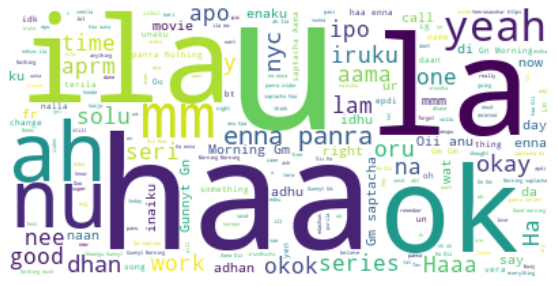

In [254]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Author name Anubharathy


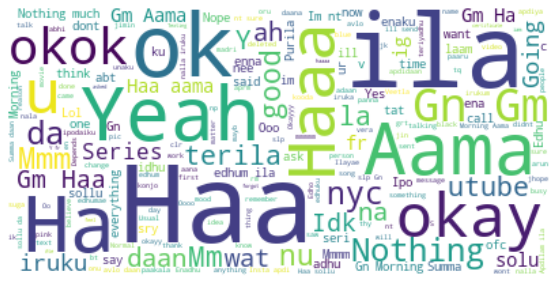

Author name Veeramanohar


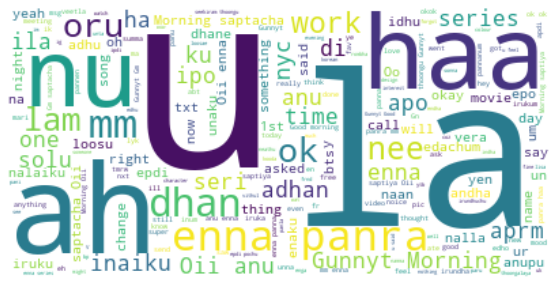

In [255]:
for i in range(len(authors_list)):
  dummy_df = messages_df[messages_df['Author'] == authors_list[i]]
  text = " ".join(review for review in dummy_df.Message)
  stopwords = set(STOPWORDS)
  #Generate a word cloud image
  print('Author name',authors_list[i])
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  #Display the generated image   
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()